<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/visionBlocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions
- great animated explanation (https://www.youtube.com/@animatedai)
-In general, does it make sense to initialize the conv weights with zero? what about the weights of fc layers?
- Check this specific case called Zero convolution:  https://arxiv.org/pdf/2302.05543.pdf and https://github.com/lllyasviel/ControlNet/blob/main/docs/faq.md"
-depth-wise conv and #params
-Group conv: advantages and # params
-Point conv and #params
-Dilated conv, when is it useful? (study UNet, how it is improved by DeepLab, and how DeepLab uses dilataed conv for this?)
- For the 3 subtopics below,
  - refer to https://github.com/FrancescoSaverioZuppichini/BottleNeck-InvertedResidual-FusedMBConv-in-PyTorch
  -bottleneck block
  -Inverted bottleneck block
  -Fused Inverted bottleneck block
-preferred data layout for conv is BHWC, how to enable it? what about opthers layers not supporting NHWC?
 https://docs.mosaicml.com/projects/composer/en/latest/method_cards/channels_last.html#technical-details"

# Answers

- In general, does it make sense to initialize the conv weights with zero? what about the weights of fc layers?
  - This is a trick question. If there is ReLu based non-linearities, it would be 0. It would be non-zero for linear layers, leaky Relus etc.
  - For Relu
    - Since conv layers can be represented as matrix multiplication, it has the same mathematical structure as a fc layer. If the weights and biases are 0, activations are always zero and gradients are always 0.
    - Here is why it is zero with standard Relu
      - A = WX + B
      - H = Relu(A)
      - dh/dw = d(Relu(A)) / dw
      - dh/dw = A * dA / dw
      - dh/dw = A * X.T
    - If A is zero, gradient updates are always zero.
  - Zero convolution is 1*1 convolutions with linear activation, but  weights and biases initialized to zero. In this case gradients are non zero as shown in
  [Gradient for linear layer is non zero](https://github.com/lllyasviel/ControlNet/blob/main/docs/faq.md)
- Control net
  - Freeze original model during training and create trainable copy blocks.
  - Using [zero convolutions](https://reframe.is/wiki/ControlNet-Explained-3842b7f090a046eda565a55d7a01ec03/) resulted in faster training times since only weights that are really necessary are learnt.
  - Freezed original model ensures knowledge learnt from pretaining is preserverd.
  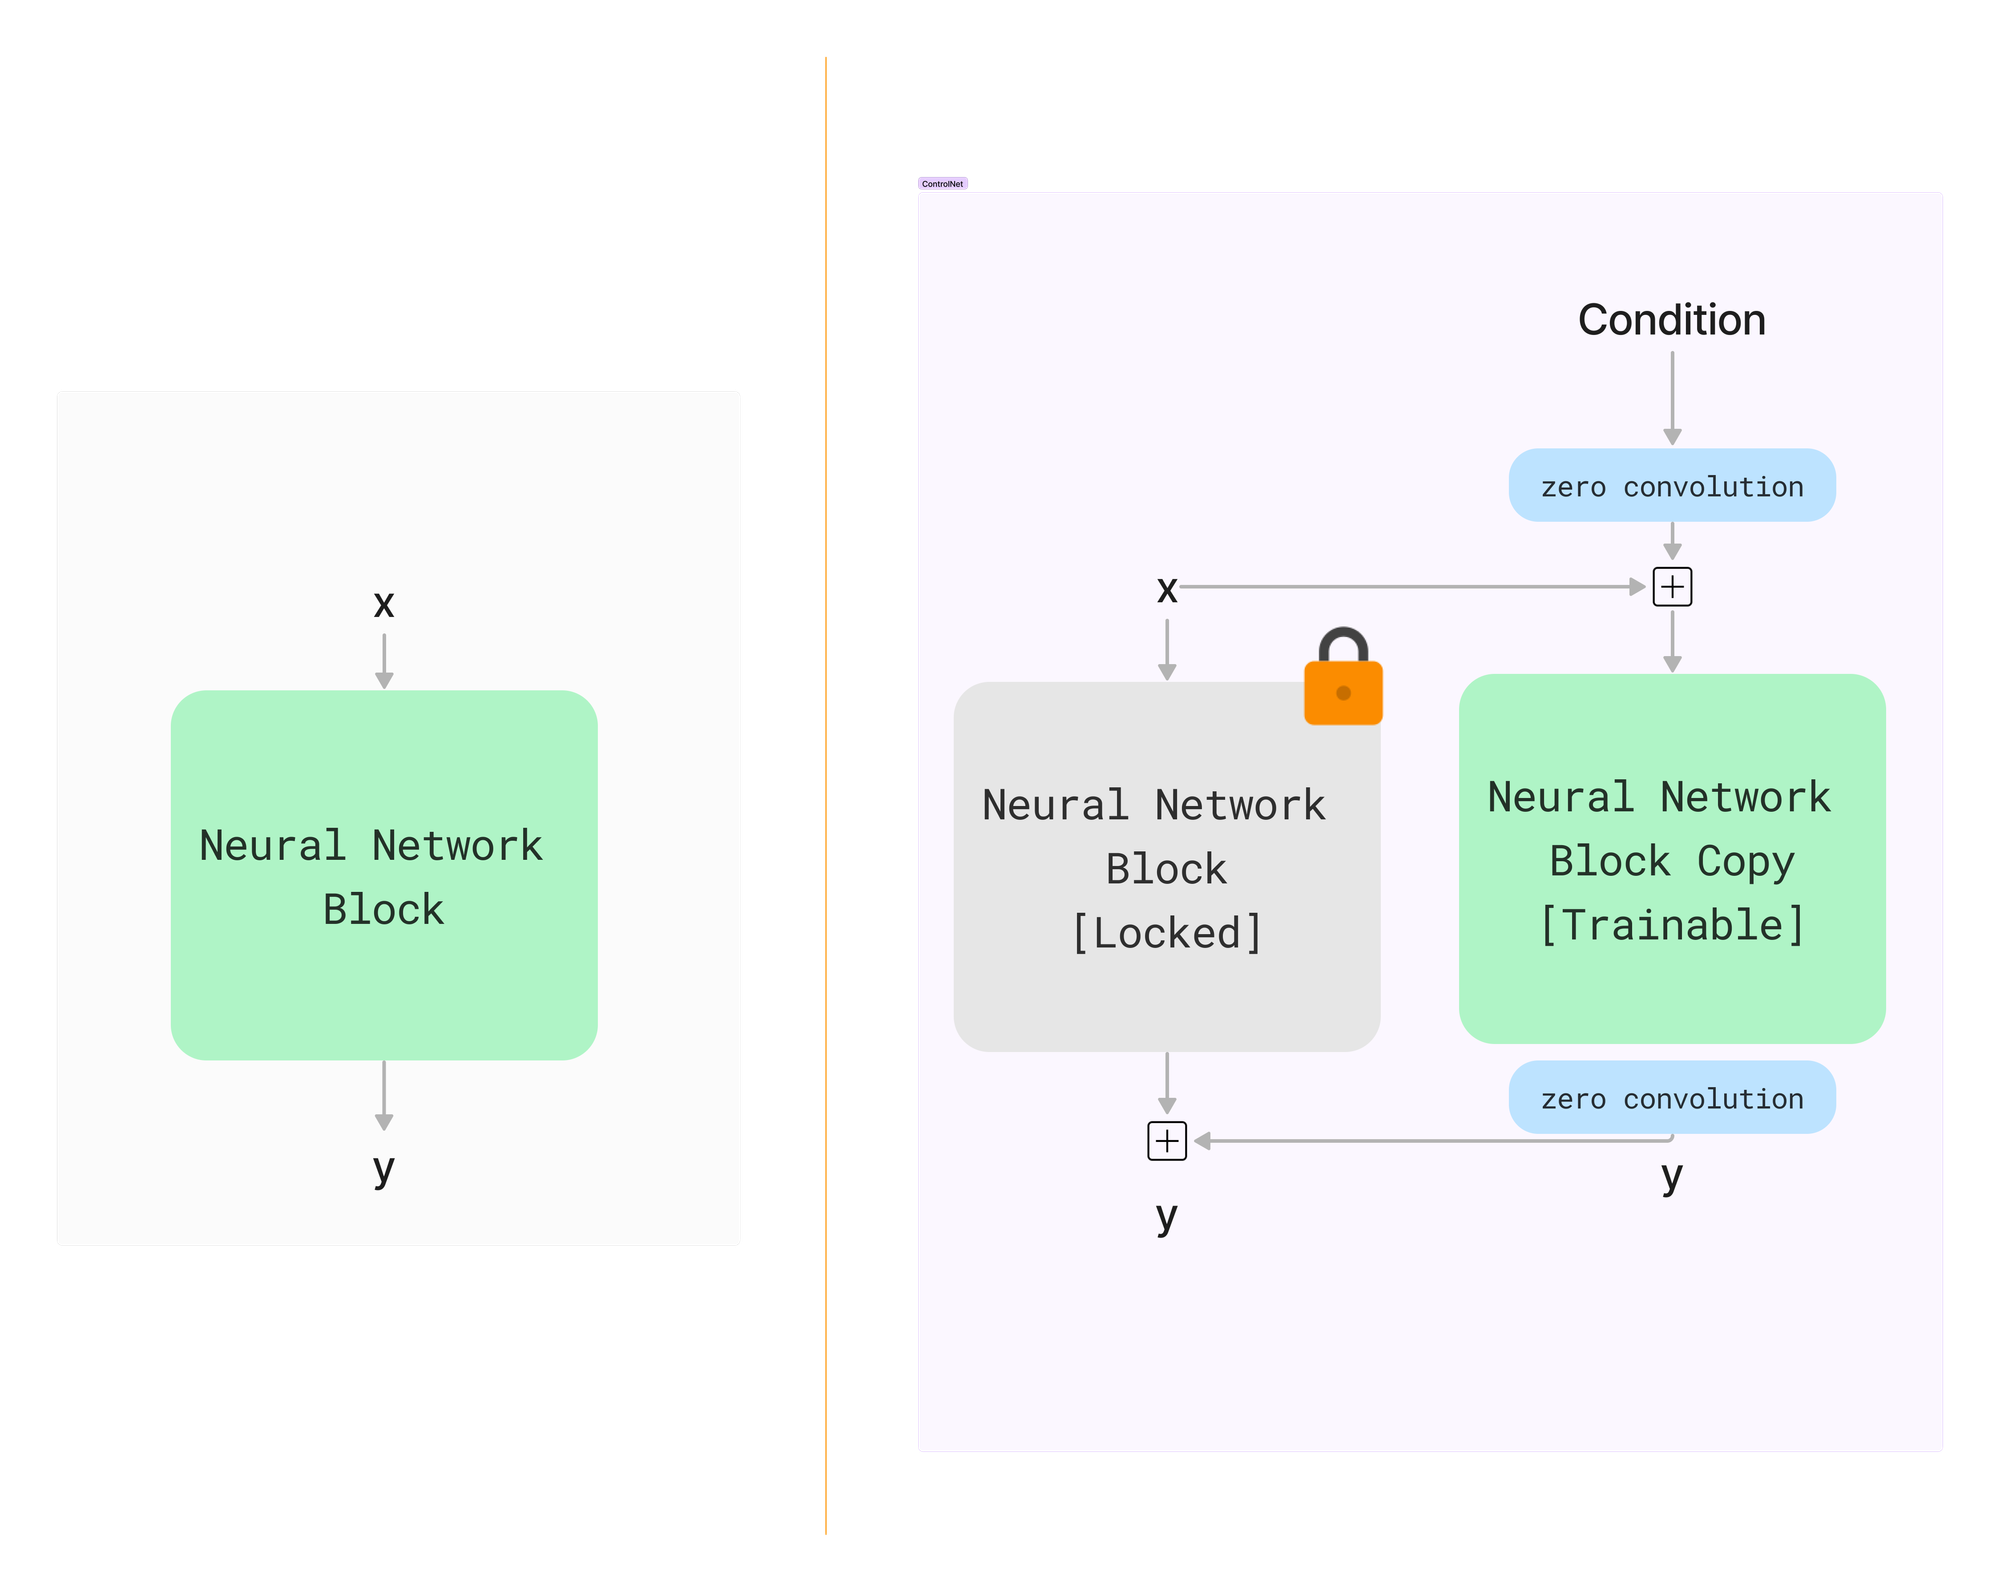

- Groupwise convolutions

  - In standard convolution from (c_i, h, w) with kernel size k, stride s and padding p.
    - For valid padding k = 2p and ignore bias for now.
    - Number of parameters = `(c_i * c_o * k * k )`
    - Shape of output = `(c_o, h/s + 1, w/s + 1)`
    - Amount of computation involved = `c_o * h/s * w/s * k * k * c_i`
  - If we divide input into 2 groups along channel dimension, each input is (c_i/2, h, w) and each output is (c_o/2, h, w)
    - Number of parameters is cut by 2 `(c_i*c_o*k*k)/4` + `(c_i*c_o*k*k)/4`
    - Shape of output is unchanged since outputs from groups are stacked together `(c_o, h/s + 1, w/s + 1)`
    - Amount of computation invovled is cut by 2
      `(c_o * h/s * w/s * k * k * c_i)/4 + (c_o * h/s * w/s * k * k * c_i)/4`
    - Now we are losing some expressivity power from the network since the groups are non interacting. Setting group size to number of channels in input is depth wise conv.

- Pointwise convolution
  - Apply 1*1 convolution along channel dimension to reintroduce interactivity among groups at low cost
   - For point wise network
    - Number of parameters = `(c_i * c_i)`
    - Computational cost = `h/s * w/s * c_i * c_i`

- Depthwise seperable convolutions
  - Set group size = number of channels and introduce point wise convolution to reintroduce expressivity.
  - Input is (c_i, h, w), kernel size k, stride s, padding p and group size g
  - For depth wise network,
    - Number of parameters = `(k * k * c_i)`
    - Computation cost = `h/s * w/s * k * k * c_i`
  - For point wise network
    - Number of parameters = `(c_i * c_i)`
    - Computational cost = `h/s * w/s * c_i * c_i`
  - Adding up depth wise and point wise
    - Number of parameters = `(k * k * c_i)` + `(c_i * c_i)`
    - Computational cost = `h/s * w/s * k * k * c_i` + `h/s * w/s * c_i * c_i`
  - For k = 3
    - Computational cost ratio is,
      `c_i*c_i*h*w*9` / (`c_i * 9 * h * w` + `c_i*c_i*h*w`) = `9 / (9/c_i + 1)`
    - if c_i is 3, cost is reduced by 2.25. if c_i = 64, cost is reduced by nearly 9x.


## Dilated convolutions
  - Introduce holes into images. Broader receptive field with same parameters, computational cost. [Video](https://www.youtube.com/watch?v=0Lg_V0Um-1Q&ab_channel=JorisvanLienen)
  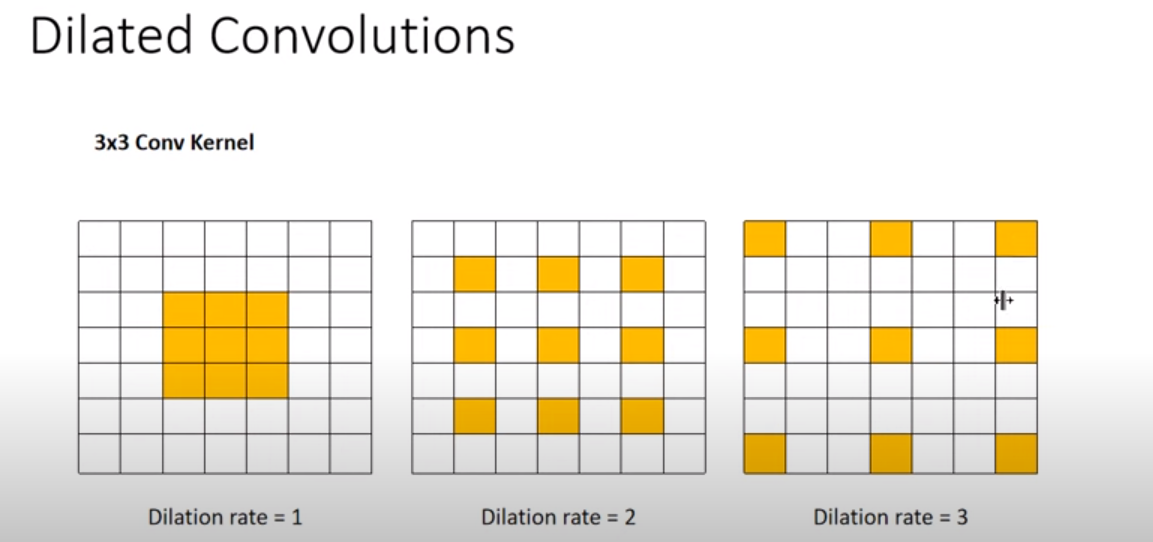

  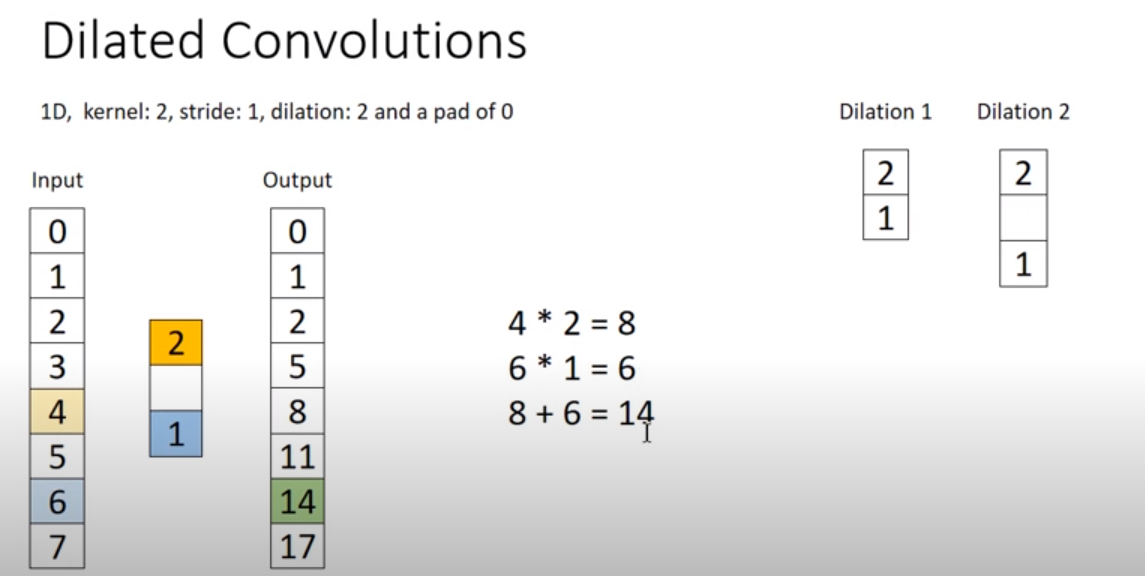

- UNet
  - 4 down blocks, one bottleneck block, 4 up block
  - Used for image to image translation.
  - Tension between semantics and location
    - Semantic info captured in bottleneck, location info copied from earlier layers. Best of both the worlds.
  - No FC layers.


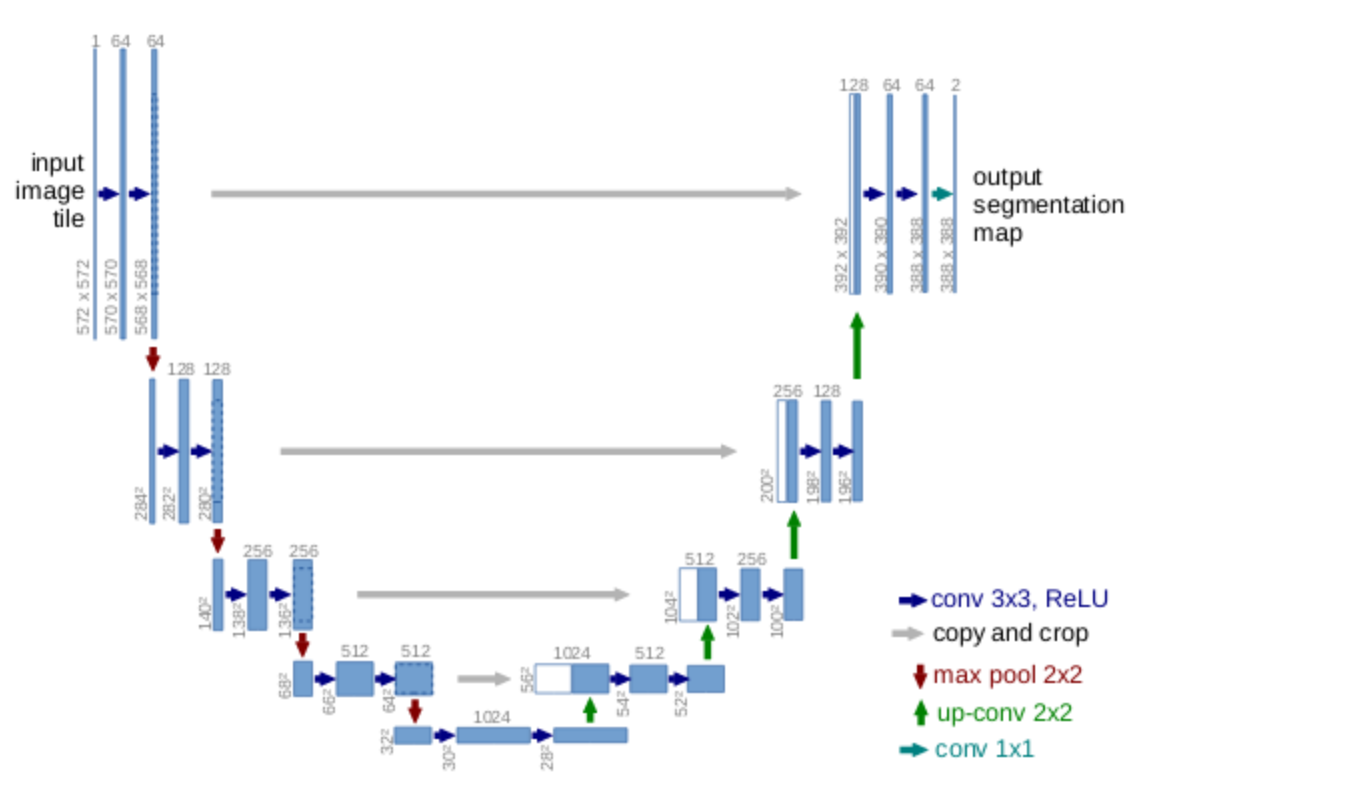

- Challenges in semantic segmentation
  - Objects are of different scale
  - Feature resolution of input is reduced after encoder
  - Reduced Localization accuracy since standard CNNs are translation invariant
- DeepLabV2
  - Dilated conv + Dilated conv parallel blocks like inception + CRF
  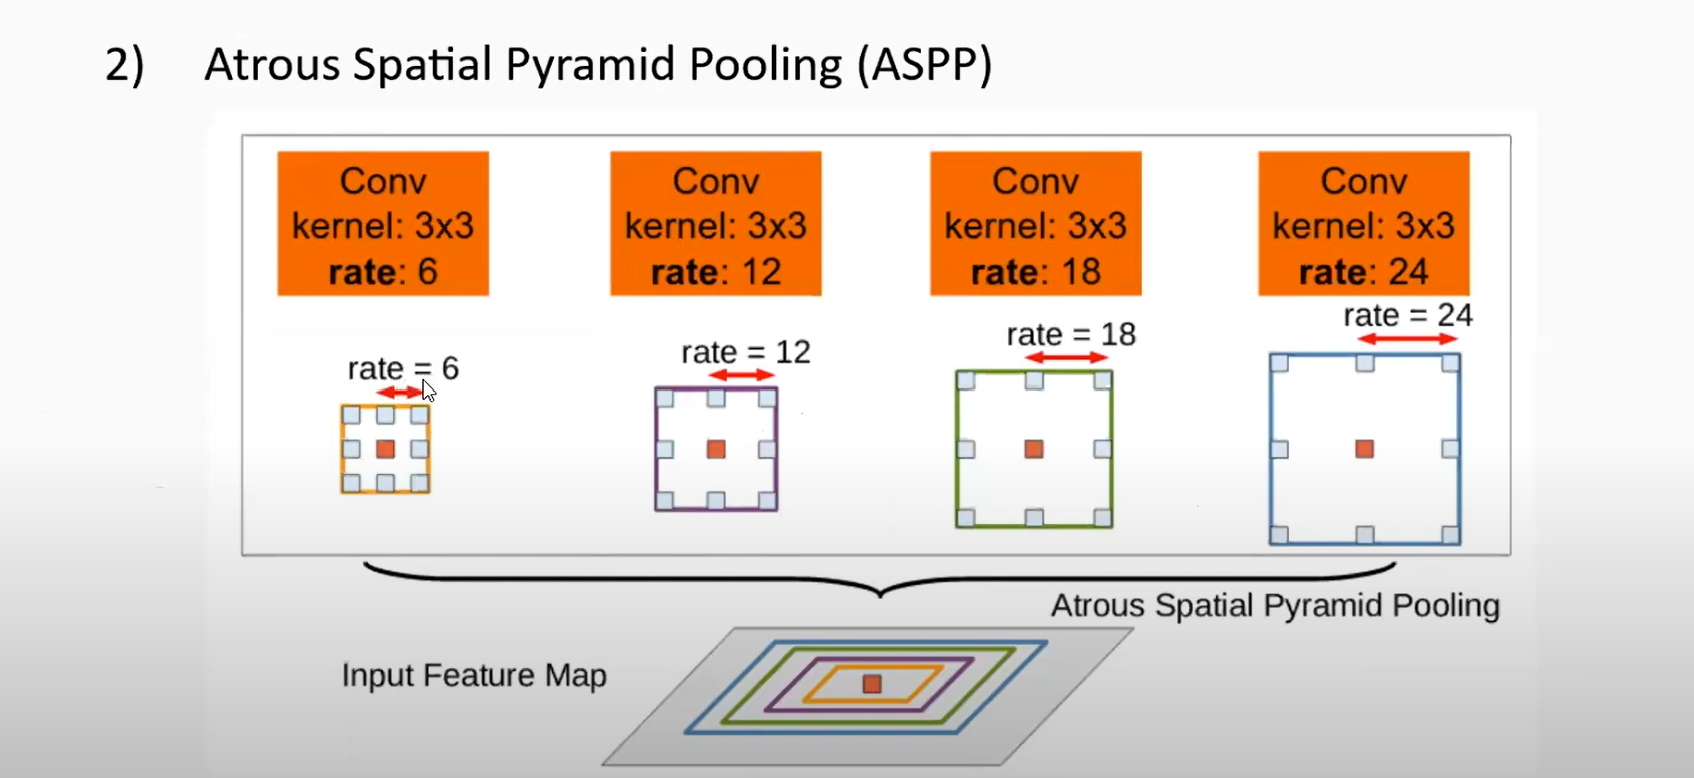


- [Demo](https://colab.research.google.com/drive/1vLNE_pLM6Msoo9caj19AuAt4qpl9VftV#scrollTo=ex_xWsiz2pCw) on effect of of different dilation filters

- Channels last
  - NVIDIA GPUs perform convolutions in NHWC and not NCHW.
    - Use functional API to do it. cf.apply_channels_last(model)
  - Putting channels last works for layers like CNNs.
    - Might introduce additional overhead for things like Unet
    - I think it is because concat operator does not have channel last support. I don't see it here https://github.com/pytorch/pytorch/wiki/Operators-with-Channels-Last-support

## Blocks

### ResBlock
  - WHat was new ?
    - Add input to output. Useful to build deep networks by allowing gradient propagation
    - Use shortcut to match shape of input with output from residual
  - Is it still used ?
    - Yes

### BottleneckBlock
- What was new ?
  - 3 conv layers without bottleneck
    - CONV(C, 3, 3) -> CONV(C, 3, 3) -> CONV(C, 3, 3)
  - 3 conv layers with bottleneck
    - CONV(C/4, 1, 1) -> CONV(C/4, 3, 3) -> CONV(C, 1, 1)
  - Faster than doing 3 convs in channel space
  - Computational cost
    - Standard CNN Cost = $(C_i * C_o * W * H * k * k)$
    - Old cost = $3 * ( W * H * C * C * 9 ) = 27X$
    - New cost = $(W*H*C*C)/2 + (W*H*C/4*C/4*9) = 1.1X$
  - For kernel size 3 and bottleneck factor 4, computational cost is reduced by ¬25x.
- Is it still relevant
  - Probably ?

### MBCONV
- What was new ?
  - aka inverted residual block according to [papersWithCode](https://paperswithcode.com/method/inverted-residual-block)
  - Increase channel resolution and apply depth wise convs in increased channel space
  - $Conv(4*C, 1, 1), CONV(4C, 3, 3, groups=C), CONV(C, 1, 1)$
- Is it still relevant ?
  - no. Depth wise conv is too slow replaced with FusionMBBlock


### FusedMBBLOCk
- What was new ?
  - Depthwise convs are slow, so fuse $1*1$ conv with $3*3$ conv
- Is it stilkl relevant ?
  - No.

### Things done
- Meta points
  - Felt that I did too many random things, I suppose people have different learning styles.
  - Felt a lot of tension between understanding basics vs keeping upto date with state of the art. Feeling of drowning in an ocean.
- [Convolution](https://colab.research.google.com/drive/1PycqdRxwg7IYBt6nDz3BRtSnNfSWXoek)
- [Pooling](https://colab.research.google.com/drive/1Vd6jTbUP5wv_xvOApQbzt63EOwnU7LzG)
- [LeNet](https://colab.research.google.com/drive/1YwvqDBu6MpUOrF1vRWqL-hZUZkme0jqH)
- [AlexNet](https://colab.research.google.com/drive/1FmRyabNfzMQu1Gx8mvQhxlelzsOBb3H8)
- [VGG](https://colab.research.google.com/drive/1IHoE04BIFPt5hN4ge0Dj907rkToYsZfo)
- [GpuNotes](https://colab.research.google.com/drive/1B90Aor0WZdPrzt91fK69e-n1QdzG0Iwl)
- [ResNext](https://colab.research.google.com/drive/1AbdRYrw4l9b_EC--HnwV-SD4I481AKbO)
- [ResNetWithStochasticDepth](https://colab.research.google.com/drive/1uqIn5NnLkHDLmYJnHdHzcrLwwTRcLuC2)
